Titanic another file

In [264]:
%matplotlib inline
import torch
import pandas as pd
import numpy as np
import re as re
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [3]:
train = pd.read_csv('./train.csv', header = 0, dtype={'Age': np.float64})
test  = pd.read_csv('./test.csv' , header = 0, dtype={'Age': np.float64})
full_data = [train, test]

Feature Engineering

Here, credit must be extended to Sina's very comprehensive and well-thought out notebook for the feature engineering ideas so please check out his work

[Titanic Best Working Classfier : by Sina](https://www.kaggle.com/sinakhorami/titanic-best-working-classifier)

In [4]:
# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
dataset

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,892,3,"Kelly, Mr. James",1,2,0,0,330911,0,NaN,2,16,0,1,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,2,1,0,363272,0,NaN,0,32,0,2,0,3
2,894,2,"Myles, Mr. Thomas Francis",1,3,0,0,240276,1,NaN,2,25,0,1,1,1
3,895,3,"Wirz, Mr. Albert",1,1,0,0,315154,1,NaN,0,16,0,1,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,1,1,1,3101298,1,NaN,0,44,0,3,0,3
5,897,3,"Svensson, Mr. Johan Cervin",1,0,0,0,7538,1,NaN,0,26,0,1,1,1
6,898,3,"Connolly, Miss. Kate",0,1,0,0,330972,0,NaN,2,20,0,1,1,2
7,899,2,"Caldwell, Mr. Albert Francis",1,1,1,1,248738,2,NaN,0,28,0,3,0,1
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",0,1,0,0,2657,0,NaN,1,41,0,1,1,3
9,901,3,"Davies, Mr. John Samuel",1,1,2,0,A/4 48871,2,NaN,0,23,0,3,0,1


In [5]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

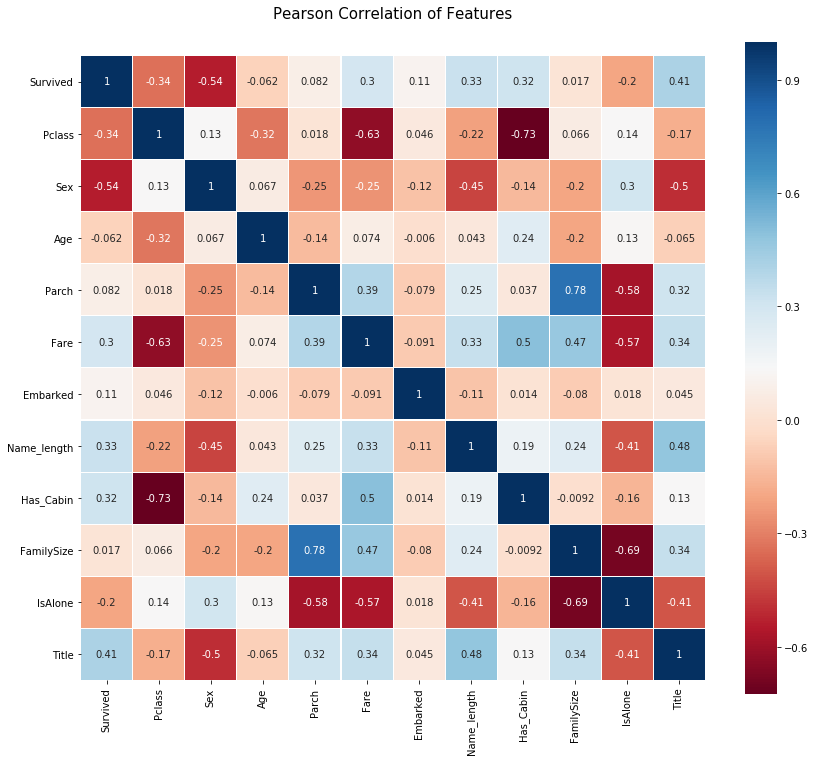

In [6]:
# Find correlation between feature
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)


In [7]:
input_size = train.shape[1]
print(input_size)

12


Start creating the `Dataset`

In [2]:
train.to_csv('cleaned_train.csv')

NameError: name 'train' is not defined

In [3]:
test.to_csv('cleaned_test.csv')

NameError: name 'test' is not defined

Start compettion here!

In [386]:
df = pd.read_csv('cleaned_train.csv', index_col=0)

In [387]:
HEADERS = ["Pclass", "Sex", "Age", "Parch", "Fare", "Embarked", "Name_length", "Has_Cabin", "FamilySize", "IsAlone",
           "Title"]
TARGET = ['Survived']


class TitanicDataset(Dataset):
    def __init__(self, df):
        self.x_data = df[HEADERS]
        self.y_data = df[TARGET]
        self.len = self.x_data.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        x = torch.tensor(self.x_data.iloc[index].values, dtype=torch.float)
        y = torch.tensor(self.y_data.iloc[index].values, dtype=torch.float)
        return x, y

In [388]:
from sklearn.model_selection import train_test_split
# Dataframe will be split into `train and test` Do not confuse with `cleaned_test.csv` that one is a competition file
# I am talking about `cross valiation` test set
train_set, test_set = train_test_split(df, test_size=0.1)

In [389]:
# Find batch_size
from fractions import gcd
print(train_set.shape)
print(test_set.shape)
batch_size = gcd(train_set.shape[0], test_set.shape[0])
print(batch_size)

(801, 12)
(90, 12)
9


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
  """


In [390]:
train_dataset = TitanicDataset(train_set)

In [391]:
test_dataset = TitanicDataset(test_set)

In [392]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [393]:
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [394]:
# 1. Design model
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(123)
        self.fc1 = torch.nn.Linear(11, 60)
        self.fc2 = torch.nn.Linear(60, 60)
        self.fc3 = torch.nn.Linear(60, 1)
        self.dropout = torch.nn.Dropout(p=0.5)
        
        torch.nn.init.xavier_normal(self.fc1.weight)
        torch.nn.init.xavier_normal(self.fc2.weight)
        torch.nn.init.xavier_normal(self.fc3.weight)        
        
        self.sigmoid = torch.nn.Sigmoid()
        self.leakyrelu = torch.nn.LeakyReLU()
        
    def forward(self, x):
        x = self.dropout(self.sigmoid(self.fc1(x)))
        x = self.dropout(self.sigmoid(self.fc2(x)))
        x = self.dropout(self.leakyrelu(self.fc3(x)))
        return x

In [395]:
# 2. Define criterion and optimizer
model = Net()
criterion = torch.nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adadelta(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  if sys.path[0] == '':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  del sys.path[0]


In [396]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.long().view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [397]:
device = 'cpu'

In [ ]:
# 3. Train
for epoch in range(1, 6):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/801 (0%)]	Loss: 0.748061
Train Epoch: 1 [90/801 (11%)]	Loss: 0.693344
Train Epoch: 1 [180/801 (22%)]	Loss: 0.692079
Train Epoch: 1 [270/801 (34%)]	Loss: 0.686813
Train Epoch: 1 [360/801 (45%)]	Loss: 0.690990
Train Epoch: 1 [450/801 (56%)]	Loss: 0.687298
Train Epoch: 1 [540/801 (67%)]	Loss: 0.681388
Train Epoch: 1 [630/801 (79%)]	Loss: 0.690636
Train Epoch: 1 [720/801 (90%)]	Loss: 0.687571

Test set: Average loss: 0.0765, Accuracy: 64/90 (71%)

Train Epoch: 2 [0/801 (0%)]	Loss: 0.679813
Train Epoch: 2 [90/801 (11%)]	Loss: 0.695590
Train Epoch: 2 [180/801 (22%)]	Loss: 0.688433
Train Epoch: 2 [270/801 (34%)]	Loss: 0.696318
Train Epoch: 2 [360/801 (45%)]	Loss: 0.692773
Train Epoch: 2 [450/801 (56%)]	Loss: 0.693210
Train Epoch: 2 [540/801 (67%)]	Loss: 0.699858
Train Epoch: 2 [630/801 (79%)]	Loss: 0.692756
Train Epoch: 2 [720/801 (90%)]	Loss: 0.684359

Test set: Average loss: 0.0764, Accuracy: 64/90 (71%)

Train Epoch: 3 [0/801 (0%)]	Loss: 0.687642
Train Epoch: 3 [90/801 (1